In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from IPython.display import clear_output
from collections import Counter, OrderedDict


def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array


def drop_useless(graph_feature_df):
    return graph_feature_df.drop(columns=["network_diameter", "network_radius", "closeness_centralization", "102", "111D", "111U", 
                                          "030C", "201", "120D", "120U", "120C", "210", "300" ])

def convert_stats_numeric(stat_df):
    for column in ["thread_id", "time", "replies", "images"]:
        stat_df[column] = stat_df[column].astype(int)
    return stat_df

color_map = sns.color_palette("flare", as_cmap=True)
def color_palette(n):
    return sns.color_palette("flare", n_colors=n)

pd.set_option('display.max_columns', None)
b_path_raw = "b_collection/"
b_path_extracted = "b_collection_extracted/"
archive_path_raw = "collection_archives/"
archive_path_extracted = "archive_collection_extracted/"
pol_path_extracted = "pol_extracted/"
b_stats = convert_stats_numeric(pd.read_pickle(f"{b_path_extracted}stat_df"))
archive_stats = convert_stats_numeric(pd.read_pickle(f"{archive_path_extracted}stat_df"))
pol_stats = convert_stats_numeric(pd.read_pickle(f"{pol_path_extracted}stat_df"))
b_graph_features = pd.read_pickle(f"{b_path_extracted}graph_features_all")
archive_graph_features = pd.read_pickle(f"{archive_path_extracted}graph_features_all")
pol_graph_features = pd.read_pickle(f"{pol_path_extracted}graph_features_all")
clean_columns = [" ".join(column.split("_")) for column in drop_useless(b_graph_features).drop(columns="board").columns ]

Dieses Notebook ist wie folgt gegliedert. Zunächst wird werden die Daten über den Prozess der Erhebungen ausgegeben. 

# 1. Daten über die eigenen Erhebungen

## /b/ Collection

In [2]:
connection = sqlite3.connect(f"{b_path_raw}/b/db.sqlite")
b_collection_stats = pd.read_sql_query("SELECT * from stats", connection)
not_collected = b_collection_stats[b_collection_stats.collected == 0].shape[0]
total_seen_b = b_collection_stats.shape[0]
size_b_dataset = total_seen - not_collected
print(f"Von den insgesamt {total_seen_b} in die Datenbank eingetrangenen Threads wurden {not_collected} nicht heruntergeladen, was zu einer Größe des Datensatzes von {size_b_dataset} Threads führt.")

Von den insgesamt 326955 in die Datenbank eingetrangenen Threads wurden 417 nicht heruntergeladen, was zu einer Größe des Datensatzes von 326538 Threads führt.


## Archive Collection

In [10]:
connection = sqlite3.connect(f"{archive_path_raw}/archive_collection/db.sqlite")
archive_collection_stats = pd.read_sql_query("SELECT * from stats", connection)
not_collected = archive_collection_stats[archive_collection_stats.collected == 0].shape[0]
total_seen_archive = archive_collection_stats.shape[0]
size_archive_dataset = total_seen - not_collected
board_statitic_string = f"Von diesen {size_archive_dataset} Threads gehören "
for board in archive_collection_stats.board.unique():
    board_statitic_string = board_statitic_string+f"{archive_collection_stats[(archive_collection_stats.board == board) & (archive_collection_stats.collected > 0)].shape[0]} zum Board {board}, "
board_statitic_string = board_statitic_string.strip(", ")+"."
print(f"Von den insgesamt {total_seen_archive} in die Datenbank eingetrangenen Threads wurden {not_collected} nicht heruntergeladen, was zu einer Größe des Datensatzes von {size_archive_dataset} Threads führt.", board_statitic_string)

Von den insgesamt 935506 in die Datenbank eingetrangenen Threads wurden 10468 nicht heruntergeladen, was zu einer Größe des Datensatzes von 925038 Threads führt. Von diesen 925038 Threads gehören 95379 zum Board biz, 93811 zum Board int, 64280 zum Board mu, 294423 zum Board pol, 68199 zum Board r9k, 115821 zum Board tv, 193125 zum Board v.


# 2. Code zur Verifikation der korrekten Extraktion der Textdaten

In [77]:
raw_post_df = pd.read_pickle(f"{b_path_extracted}post_df_raw")
clean_post_df = pd.read_pickle(f"{b_path_extracted}post_df_extracted")

In [92]:
raw_sample_df = raw_post_df.sample(n=1000)
clean_sample_df = clean_post_df[clean_post_df.index.isin(raw_sample_df.index)]

In [104]:
verification_df = raw_sample_df[['no', 'com']].set_index('no').join(clean_sample_df[["full_string", "quoted_list", "no"]].set_index('no'))

In [115]:
verification_list = []
for index, row in verification_df.iterrows():
    print(row.com)
    print(row.full_string)
    print(row.quoted_list)
    user_input = input("1 for true, 0 for false")
    if user_input in ["1", "0"]:
        verification_list.append(True if user_input == "1" else False)
    else:
        verification_list.append(None)
    clear_output()
verification_df['verification_result'] = verification_list

# 3. Descriptive Statistik der Datensätze

In [123]:
pol_stats[filter_on_stats(pol_stats)].shape[0]

1365217

In [125]:
print(f"Nach dem Filtern von Relevanten Threads wie in der Arbeit beschrieben ergeben sich folgende Anzahlen an Threads für die Auswertung: {b_stats[filter_on_stats(b_stats)].shape[0]} Threads aus /b/ {archive_stats[filter_on_stats(archive_stats)].shape[0]} für den Archiv-Datensatz und {pol_stats[filter_on_stats(pol_stats)].shape[0]} im Falle /pol/s")

Nach dem Filtern von Relevanten Threads wie in der Arbeit beschrieben ergeben sich folgende Anzahlen an Threads für die Auswertung: 105100 Threads aus /b/ 337106 für den Archiv-Datensatz und 1365217 im Falle /pol/s


In [187]:
sum(filter_on_stats(pol_stats))

1365217

Text(0, 0.5, 'Anzahl an Threads')

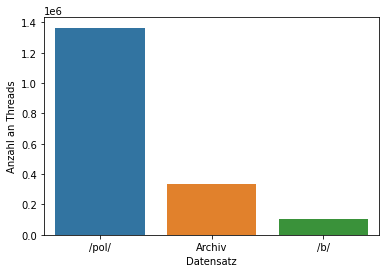

In [190]:
g = sns.barplot(x=['/pol/', 'Archiv', "/b/"], y=[sum(filter_on_stats(pol_stats)), sum(filter_on_stats(archive_stats)), sum(filter_on_stats(b_stats))], orient="v")
g.set_xlabel("Datensatz")
g.set_ylabel("Anzahl an Threads")

Text(0, 0.5, 'Anzahl an Threads')

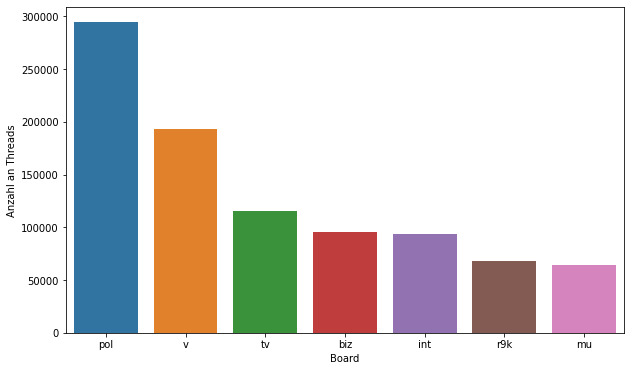

In [193]:
counter = Counter(archive_stats.board)
board_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
g = sns.barplot(x=list(board_dict.keys()), y=list(board_dict.values()), order=list(board_dict.keys()), orient="v")
g.set_xlabel("Board")
g.set_ylabel("Anzahl an Threads")

In [198]:
board_dict

OrderedDict([('pol', 294423),
             ('v', 193125),
             ('tv', 115821),
             ('biz', 95379),
             ('int', 93811),
             ('r9k', 68199),
             ('mu', 64280)])

Text(0.5, 0, 'Replies')

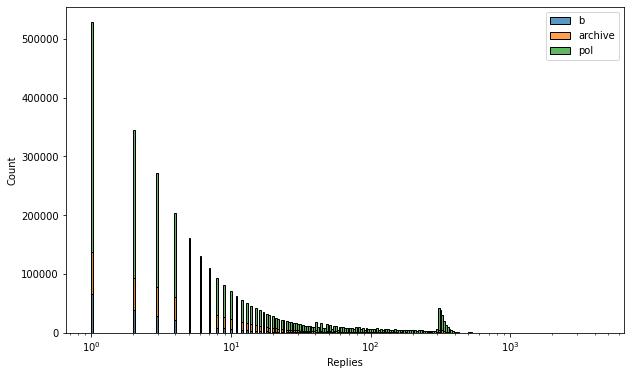

In [197]:
plt.figure(figsize=(10,6))

ax = sns.histplot(data={"b": b_stats.replies.apply(lambda x: x+1).to_numpy(), 
                        "archive": archive_stats.replies.apply(lambda x: x+1).to_numpy(), 
                        "pol":pol_stats.replies.apply(lambda x: x+1).to_numpy()},
                  multiple="stack", log_scale=True, stat="count")
ax.set_xlabel("Replies")

Text(0.5, 0, 'Replies')

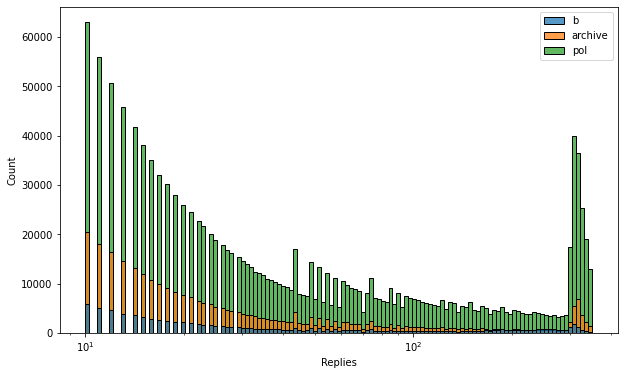

In [130]:
plt.figure(figsize=(10,6))

ax = sns.histplot(data={"b": b_stats[filter_on_stats(b_stats)].replies.to_numpy(), 
                        "archive": archive_stats[filter_on_stats(archive_stats)].replies.to_numpy(), 
                        "pol":pol_stats[filter_on_stats(pol_stats)].replies.to_numpy()},
                  multiple="stack", log_scale=True, stat="count")
ax.set_xlabel("Replies")

Text(0.5, 0, 'Replies')

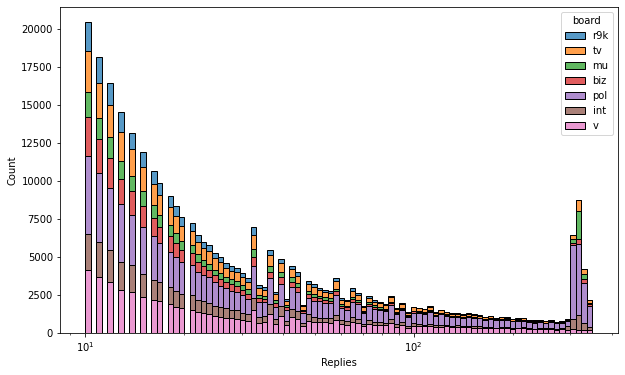

In [131]:
plt.figure(figsize=(10,6))
ax = sns.histplot(x="replies", data=archive_stats[filter_on_stats(archive_stats)], 
                  hue='board', log_scale=True, multiple="stack")
ax.set_xlabel("Replies")

In [277]:
archive_text_df = pd.read_pickle("archive_collection_extracted/text_df")
archive_text_df_pre =  pd.read_pickle("archive_collection_extracted/text_df_preprocessed")

In [290]:
archive_text_df.full_text[archive_text_df.thread_id == 510500207].to_list()

["Behold, the most iconic video game female of all time. No, not Lara Croft, nor Chun-Li , not Princess Peach either. Tifa and Samus aren’t even top 5, LMAO. It’s Ms. Pacman all the way. Peach is more iconic >>510500207 >>510500207 >Ms Pac-Man >Lara Croft >Chun-Li >Princess Peach Who’s number 5 then? >>510500207 I'm just gonna come out and say it. *inhales* I WANNA FUCK MS PACMAN What ever happened with the court case between Bamco and AtGames? >>510503243 Ahri Why is she called Ms. Pac-Man and not simply Pac-Woman? >>510503782 https://www.newgrounds.com/portal/v iew/736780 >>510506394 because pac-man is a surname It's so weird how even today Namco really doesn't like acknowledging her. Do they even own the rights to her? "]

In [293]:
archive_text_df_pre.preprocessed_text[archive_text_df_pre.thread_id == 510500207].to_list()

[['behold',
  'iconic',
  'video',
  'game',
  'female',
  'time',
  'lara',
  'croft',
  'chun',
  'li',
  'princess',
  'peach',
  'tifa',
  'samus',
  'lmao',
  'ms',
  'pacman',
  'way',
  'peach',
  'iconic',
  'ms',
  'pac',
  'man',
  'lara',
  'croft',
  'chun',
  'li',
  'princess',
  'peach',
  'numb',
  'go',
  'to',
  'come',
  'inhale',
  'wanna',
  'fuck',
  'ms',
  'pacman',
  'happen',
  'court',
  'case',
  'bamco',
  'atgames',
  'ahri',
  'call',
  'ms',
  'pac',
  'man',
  'simply',
  'pac',
  'woman',
  'httpswwwnewgroundscomportalv',
  'iew',
  'pac',
  'man',
  'surname',
  'weird',
  'today',
  'namco',
  'like',
  'acknowledge',
  'right']]

In [ ]:
pd.read_pickle("archive_collection_extracted/text_df")

In [276]:
stat_df[stat_df.replies == 10]

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,no_posts_log,no_posts
5,59086906,r9k,took-pictures-of-the-hungarian-parliament,1594722784,1594738561,10,5,0,0,en,True,2.397895,11
81,58632023,r9k,what-do-you-imagine-a-2d-girl-feels-like,1592099093,1592112939,10,1,0,0,en,True,2.397895,11
94,58924840,r9k,never-give-up-8,1593772807,1593786599,10,1,0,0,en,True,2.397895,11
130,58442944,r9k,be-me,1591037465,1591049200,10,2,0,0,en,True,2.397895,11
195,58593257,r9k,you-cant-be-a-robot-if-you-werent-born-in-a,1591880029,1591894207,10,2,0,0,en,True,2.397895,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
924890,510500207,v,behold-the-most-iconic-video-game-female-of-all,1590975174,1590981786,10,3,0,0,en,True,2.397895,11
924898,517843008,v,comfy-jrpgs,1595305222,1595309165,10,1,0,0,en,True,2.397895,11
924912,511967998,v,what-the-fuck-did-valve-mean-by-this,1591930541,1591932211,10,1,0,0,en,True,2.397895,11
924990,508906038,v,start-game,1589984168,1589987751,10,1,0,0,en,True,2.397895,11


In [271]:
b_posts = pd.read_pickle("b_collection_extracted/post_df_extracted")

In [274]:
b_posts[b_posts.full_string.isin(['>>825664146 6 or 7 now >>825661360 ', '>>824205614 im no ready too >>824205564 ','>>830864445 >>830864489 >>830864535 >>830864663 bitch looks like a princess ', '>>830829476 ', 'Here is more '])].full_string.to_numpy()

array(['Here is more ', '>>830829476 ', 'Here is more ',
       '>>825664146 6 or 7 now >>825661360 ',
       '>>824205614 im no ready too >>824205564 ', 'Here is more ',
       'Here is more ',
       '>>830864445 >>830864489 >>830864535 >>830864663 bitch looks like a princess '],
      dtype=object)

In [2]:
def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array

def drop_useless(graph_feature_df):
    return graph_feature_df.drop(columns=["network_diameter", "network_radius",  "102", "111D", "111U", 
                                          "030C", "201", "120D", "120U", "120C", "210", "300" ])

In [ ]:
drop_useless(b_graph_features)

In [39]:
palette = sns.color_palette("Blues", as_cmap=True)

In [58]:
clean_columns = [" ".join(column.split("_")) for column in drop_useless(b_graph_features).drop(columns="board").columns ]

In [59]:
clean_columns

['max degree',
 'average degree',
 'density',
 'longest path',
 'transitivity',
 'average clustering',
 'degree centralization',
 'betweenness centralization',
 'closeness centralization',
 '003',
 '012',
 '021D',
 '021U',
 '021C',
 '030T']

In [171]:
?round

In [173]:
drop_useless(b_graph_features)[filter_on_stats(b_stats)].describe().round(4)

,max_degree,average_degree,density,longest_path,transitivity,average_clustering,degree_centralization,betweenness_centralization,closeness_centralization,003,012,021D,021U,021C,030T
count,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000,96256.0000,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000,105100.0000
mean,0.5427,2.0552,0.0391,0.1706,0.0924,0.0137,0.5064,0.0148,1.1222,0.8197,0.1262,0.0009,0.0467,0.0062,0.0003
std,0.2123,0.2846,0.0295,0.1171,0.1495,0.0274,0.2193,0.0201,0.4562,0.1305,0.0994,0.0058,0.0552,0.0090,0.0024
min,0.0250,1.1250,0.0028,0.0062,0.0000,0.0000,0.0003,0.0000,0.0044,0.0482,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3713,1.9048,0.0112,0.0861,0.0000,0.0000,0.3327,0.0028,0.7674,0.7233,0.0384,0.0000,0.0056,0.0003,0.0000
50%,0.5238,2.0000,0.0344,0.1429,0.0000,0.0000,0.4796,0.0076,1.0968,0.8372,0.1020,0.0000,0.0248,0.0024,0.0000
75%,0.7000,2.1321,0.0625,0.2222,0.1445,0.0176,0.6667,0.0180,1.4619,0.9421,0.1894,0.0001,0.0682,0.0085,0.0000
max,1.0000,32.9032,0.3125,0.9753,0.5000,0.4589,1.0000,0.2567,2.1111,0.9902,0.5805,0.2757,0.2727,0.1273,0.3946


In [177]:
drop_useless(b_graph_features)[filter_on_stats(b_stats)].describe().round(4).transpose().to_excel(f"{b_path_extracted}graph_feature_describe.xlsx")

In [ ]:
96256

[Text(0, 0.5, 'max degree'),
 Text(0, 1.5, 'average degree'),
 Text(0, 2.5, 'density'),
 Text(0, 3.5, 'longest path'),
 Text(0, 4.5, 'transitivity'),
 Text(0, 5.5, 'average clustering'),
 Text(0, 6.5, 'degree centralization'),
 Text(0, 7.5, 'betweenness centralization'),
 Text(0, 8.5, '003'),
 Text(0, 9.5, '012'),
 Text(0, 10.5, '021D'),
 Text(0, 11.5, '021U'),
 Text(0, 12.5, '021C'),
 Text(0, 13.5, '030T')]

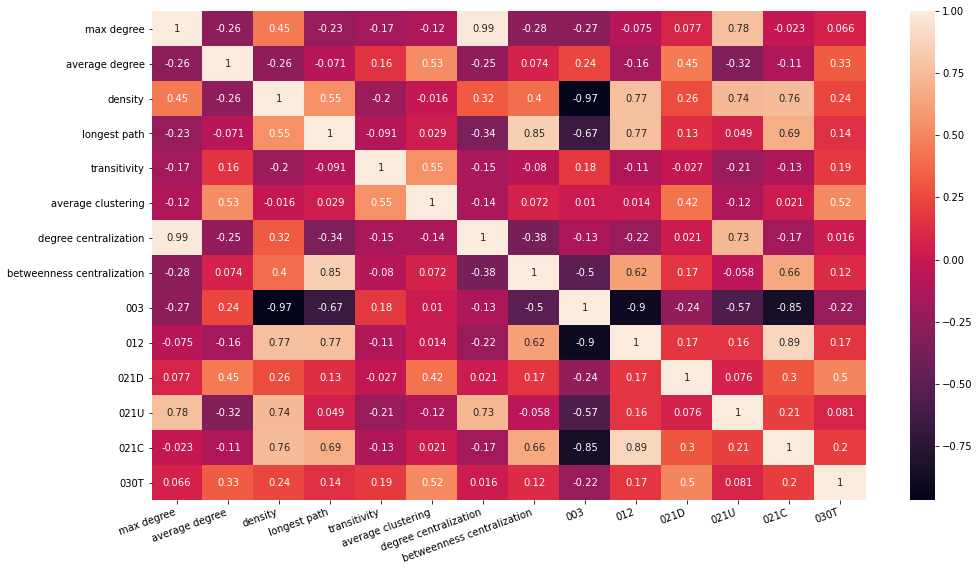

In [180]:
plt.figure(figsize=(16,9))
g = sns.heatmap(drop_useless(b_graph_features)[filter_on_stats(b_stats)].corr(), annot=True)
g.set_xticklabels(clean_columns, rotation=20, horizontalalignment='right')
g.set_yticklabels(clean_columns) 


In [179]:
?pd.DataFrame.corr

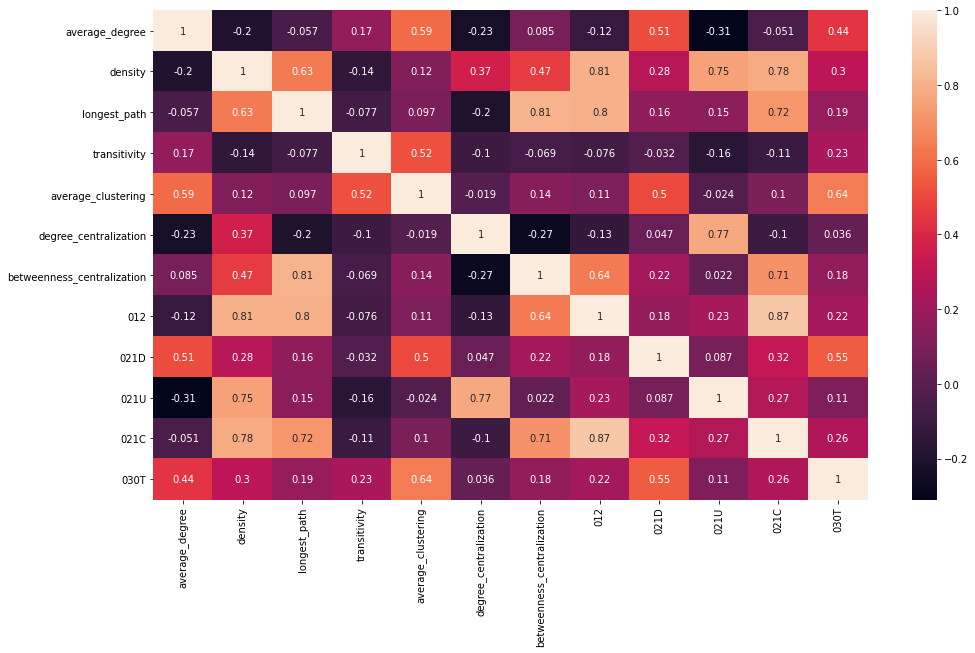

In [185]:
plt.figure(figsize=(16,9))
g = sns.heatmap(drop_useless(archive_graph_features)[filter_on_stats(archive_stats)].drop(columns=[ "max_degree", "003"]).corr(), annot=True)


entfernen: Triade 003, Max Degree,

In [24]:
drop_useless(b_graph_features)[filter_on_stats(b_stats)].corr()

,max_degree,average_degree,density,longest_path,transitivity,average_clustering,degree_centralization,betweenness_centralization,closeness_centralization,003,012,021D,021U,021C,030T
max_degree,1.000000,-0.262143,0.446480,-0.230067,-0.165442,-0.122079,0.988019,-0.281907,0.948466,-0.273989,-0.074725,0.077217,0.775289,-0.022843,0.065956
average_degree,-0.262143,1.000000,-0.257213,-0.070536,0.157977,0.533939,-0.249680,0.073902,-0.259832,0.239351,-0.162093,0.450567,-0.317393,-0.111414,0.326605
density,0.446480,-0.257213,1.000000,0.549036,-0.200732,-0.015775,0.316904,0.395389,0.435894,-0.970084,0.771111,0.261452,0.744089,0.758343,0.242884
longest_path,-0.230067,-0.070536,0.549036,1.000000,-0.091257,0.028694,-0.343335,0.849544,-0.368212,-0.666364,0.774792,0.131621,0.048535,0.689546,0.138324
transitivity,-0.165442,0.157977,-0.200732,-0.091257,1.000000,0.551559,-0.148424,-0.079791,-0.147313,0.180385,-0.111365,-0.027010,-0.210975,-0.125678,0.185786
average_clustering,-0.122079,0.533939,-0.015775,0.028694,0.551559,1.000000,-0.136953,0.071754,-0.107798,0.010436,0.013511,0.417696,-0.118983,0.020823,0.521811
degree_centralization,0.988019,-0.249680,0.316904,-0.343335,-0.148424,-0.136953,1.000000,-0.377376,0.934134,-0.130205,-0.222590,0.021446,0.732944,-0.166541,0.016104
betweenness_centralization,-0.281907,0.073902,0.395389,0.849544,-0.079791,0.071754,-0.377376,1.000000,-0.400120,-0.503991,0.621786,0.174102,-0.058008,0.655536,0.119915
closeness_centralization,0.948466,-0.259832,0.435894,-0.368212,-0.147313,-0.107798,0.934134,-0.400120,1.000000,-0.250528,-0.117751,0.020671,0.787454,-0.057793,0.031313
003,-0.273989,0.239351,-0.970084,-0.666364,0.180385,0.010436,-0.130205,-0.503991,-0.250528,1.000000,-0.902506,-0.239028,-0.566424,-0.850802,-0.221987


In [10]:
archive_graph_features[filter_on_stats(archive_stats)].describe()

,max_degree,average_degree,density,longest_path,transitivity,average_clustering,network_diameter,network_radius,degree_centralization,betweenness_centralization,...,111D,111U,030T,030C,201,120D,120U,120C,210,300
count,337106.000000,337106.000000,337106.000000,337106.000000,337106.000000,337106.000000,0.0,0.0,337106.000000,337106.000000,...,337106.0,337106.0,337106.000000,337106.0,337106.0,337106.0,337106.0,337106.0,337106.0,337106.0
mean,0.525856,2.036341,0.043453,0.171095,0.101128,0.013494,NaN,NaN,0.482923,0.015198,...,0.0,0.0,0.000439,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.189364,0.228134,0.028954,0.103096,0.159475,0.028516,NaN,NaN,0.193583,0.018596,...,0.0,0.0,0.002436,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.022642,1.111111,0.001414,0.008621,0.000000,0.000000,NaN,NaN,0.003953,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.380682,1.900000,0.017857,0.095745,0.000000,0.000000,NaN,NaN,0.334975,0.003819,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.507937,2.000000,0.040000,0.153846,0.000000,0.000000,NaN,NaN,0.461905,0.009078,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.666667,2.104938,0.066667,0.226415,0.166667,0.016204,NaN,NaN,0.616601,0.019211,...,0.0,0.0,0.000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,24.181818,0.290909,0.958333,0.500000,0.442857,NaN,NaN,1.000000,0.266942,...,0.0,0.0,0.303383,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pol_graph_features[filter_on_stats(pol_stats)].describe()

,max_degree,average_degree,density,longest_path,transitivity,average_clustering,network_diameter,network_radius,degree_centralization,betweenness_centralization,...,111D,111U,030T,030C,201,120D,120U,120C,210,300
count,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,0.0,0.0,1.365217e+06,1.365217e+06,...,1365217.0,1365217.0,1.365217e+06,1365217.0,1365217.0,1365217.0,1365217.0,1365217.0,1365217.0,1365217.0
mean,5.171854e-01,2.037987e+00,3.636073e-02,1.495278e-01,9.937397e-02,1.156643e-02,NaN,NaN,4.829393e-01,1.215046e-02,...,0.0,0.0,2.807388e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.940076e-01,2.514253e-01,2.851216e-02,9.671328e-02,1.523390e-01,2.339614e-02,NaN,NaN,1.943878e-01,1.569843e-02,...,0.0,0.0,2.188190e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.785714e-02,1.157895e+00,1.351135e-03,5.698006e-03,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.666667e-01,1.916667e+00,1.063596e-02,7.812500e-02,0.000000e+00,0.000000e+00,NaN,NaN,3.326105e-01,2.895623e-03,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,5.000000e-01,2.000000e+00,3.003003e-02,1.308411e-01,0.000000e+00,0.000000e+00,NaN,NaN,4.643494e-01,6.868802e-03,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,6.538462e-01,2.108333e+00,5.882353e-02,1.940299e-01,1.562500e-01,1.442699e-02,NaN,NaN,6.182540e-01,1.508156e-02,...,0.0,0.0,1.133367e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000e+00,1.494164e+02,5.000000e-01,9.911504e-01,5.000000e-01,5.000000e-01,NaN,NaN,1.000000e+00,2.711111e-01,...,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [382]:
2**12

4096

In [383]:
np.math.factorial(12)

479001600